In [1]:
utils_path = "../utils"
models_path = "../models"
data_path = "../data/celebs_105"

import sys
import os
sys.path.insert(1, utils_path)
sys.path.insert(2, models_path)

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

from comet_ml import Experiment

import config

import time 
import copy
import random
from tqdm.notebook import trange, tqdm

import torchvision

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms as transformss

from MBNV3 import MobileNetV3
from MBNV3CBAM import MobileNetV3CBAM

from dataloader import mixedSets
from functions import train, evaluate, confusion, unzip_files, unzip

In [2]:
#Initialising GereralTorch class

#Setting the experiment with the API key stored in config.py
experiment = Experiment(project_name = "test", workspace = "leothesouthafrican", api_key = config.api_key)

#Report multiple hyperparameters using a dictionary
hyper_params = {
    'learning_rate': 0.001,
    'epochs': 100,
    'batch_size': 32,
    'image_size': 112,
    'image_channels': 3,
    'output_size': len(os.listdir(data_path)) - 1,
    'num_layers': 'na',
    'train_val_test_split': [0.8, 0.1, 0.1],
    'device': 'mps',
    'model_name': 'MobileNet3 with CBAM inserted instead of SE starting from a fresh model with no preloaded weights.',
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'Adam',
    'dataset': 'Celebrities 20',
    'best_model_path': 'output/MN3LCB_celebs105_t.pt',
    'loaded_model_path': 'output/MN3LCB_celebs20.pt',
    'comet_exp': experiment,
    'save_at_end': True,
}

print(f'Output Size: {hyper_params["output_size"]}')

#Setting the device
device = torch.device(hyper_params['device'])

#checking if the model is to be a loaded one and if so loading it
if hyper_params['loaded_model_path']:
    state_dict = torch.load(hyper_params['loaded_model_path']) #Loading the state dict
    model = MobileNetV3CBAM(mode='large') #Loading the model as a backbone
    model.load_state_dict(state_dict, strict= True) #Loading the state dict into the model
    print('Model Loaded')
else:
    # Loading a fresh model
    model = MobileNetV3CBAM(mode='large')

#passing the model to the device
model.to(device)

# Setting the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device) #Setting the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning_rate']) #Setting the optimizer

# Logging the hyperparameters to comet
experiment.log_parameters(hyper_params)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/e128fb0295d9434fab4f8884d5cd2065



Output Size: 105
Model Loaded


In [3]:
#defining transforms

train_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.RandAugment(),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])

test_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])

In [4]:
# Creating the dataset
train_dataset = mixedSets(data_path, train_transform, hyper_params['train_val_test_split']).get_train_dataset()
val_dataset = mixedSets(data_path, test_transform, hyper_params['train_val_test_split']).get_val_dataset()
test_dataset = mixedSets(data_path, test_transform, hyper_params['train_val_test_split']).get_test_dataset()

# Creating the dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)


Train dataset size: 14026, with 105 classes
Val dataset size: 1754, with 105 classes
Test dataset size: 1754, with 105 classes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


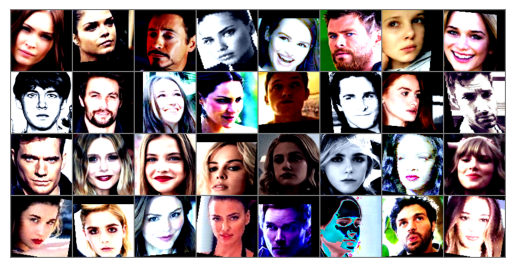

tensor(56) tensor(53) tensor(72) tensor(0)


In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [6]:
with experiment.train():
    train(model, criterion, optimizer, hyper_params, train_loader, val_loader)

Begin training...


100%|██████████| 55/55 [00:08<00:00,  6.43it/s]


Best model saved at epoch 2 with accuracy 0.1129 and loss 3.8364.
	Train Loss: 4.087 | Train Acc: 30.00%
Epoch: 02 | Epoch Time: 1m 54s
	 Val. Loss: 3.836 |  Val. Acc: 11.29%


100%|██████████| 55/55 [00:07<00:00,  6.92it/s]


Best model saved at epoch 3 with accuracy 0.1722 and loss 3.482.
	Train Loss: 3.853 | Train Acc: 10.00%
Epoch: 03 | Epoch Time: 1m 48s
	 Val. Loss: 3.482 |  Val. Acc: 17.22%


100%|██████████| 55/55 [00:08<00:00,  6.80it/s]


Best model saved at epoch 4 with accuracy 0.2395 and loss 3.0236.
	Train Loss: 2.708 | Train Acc: 20.00%
Epoch: 04 | Epoch Time: 1m 53s
	 Val. Loss: 3.024 |  Val. Acc: 23.95%


100%|██████████| 55/55 [00:07<00:00,  6.89it/s]


Best model saved at epoch 5 with accuracy 0.301 and loss 2.776.
	Train Loss: 2.548 | Train Acc: 40.00%
Epoch: 05 | Epoch Time: 1m 52s
	 Val. Loss: 2.776 |  Val. Acc: 30.10%


100%|██████████| 55/55 [00:08<00:00,  6.50it/s]


Best model saved at epoch 6 with accuracy 0.3347 and loss 2.5739.
	Train Loss: 3.653 | Train Acc: 20.00%
Epoch: 06 | Epoch Time: 1m 47s
	 Val. Loss: 2.574 |  Val. Acc: 33.47%


100%|██████████| 55/55 [00:07<00:00,  7.26it/s]


Best model saved at epoch 7 with accuracy 0.3387 and loss 2.5861.
	Train Loss: 2.604 | Train Acc: 20.00%
Epoch: 07 | Epoch Time: 1m 38s
	 Val. Loss: 2.586 |  Val. Acc: 33.87%


100%|██████████| 55/55 [00:07<00:00,  7.25it/s]


Best model saved at epoch 8 with accuracy 0.4111 and loss 2.3357.
	Train Loss: 2.856 | Train Acc: 30.00%
Epoch: 08 | Epoch Time: 1m 42s
	 Val. Loss: 2.336 |  Val. Acc: 41.11%


100%|██████████| 55/55 [00:07<00:00,  7.31it/s]


Best model saved at epoch 9 with accuracy 0.4219 and loss 2.2711.
	Train Loss: 1.856 | Train Acc: 60.00%
Epoch: 09 | Epoch Time: 1m 44s
	 Val. Loss: 2.271 |  Val. Acc: 42.19%


100%|██████████| 55/55 [00:07<00:00,  7.30it/s]


	Train Loss: 1.203 | Train Acc: 60.00%
Epoch: 10 | Epoch Time: 1m 39s
	 Val. Loss: 2.256 |  Val. Acc: 40.88%


100%|██████████| 55/55 [00:07<00:00,  7.22it/s]


Best model saved at epoch 11 with accuracy 0.4772 and loss 2.0688.
	Train Loss: 2.183 | Train Acc: 50.00%
Epoch: 11 | Epoch Time: 1m 40s
	 Val. Loss: 2.069 |  Val. Acc: 47.72%


100%|██████████| 55/55 [00:07<00:00,  7.17it/s]


	Train Loss: 1.655 | Train Acc: 40.00%
Epoch: 12 | Epoch Time: 1m 44s
	 Val. Loss: 2.057 |  Val. Acc: 46.92%


100%|██████████| 55/55 [00:07<00:00,  7.33it/s]


Best model saved at epoch 13 with accuracy 0.4909 and loss 1.9943.
	Train Loss: 2.415 | Train Acc: 20.00%
Epoch: 13 | Epoch Time: 1m 38s
	 Val. Loss: 1.994 |  Val. Acc: 49.09%


100%|██████████| 55/55 [00:07<00:00,  7.34it/s]


Best model saved at epoch 14 with accuracy 0.5086 and loss 1.9015.
	Train Loss: 1.649 | Train Acc: 60.00%
Epoch: 14 | Epoch Time: 1m 36s
	 Val. Loss: 1.902 |  Val. Acc: 50.86%


100%|██████████| 55/55 [00:07<00:00,  7.35it/s]


Best model saved at epoch 15 with accuracy 0.5154 and loss 1.9761.
	Train Loss: 2.939 | Train Acc: 20.00%
Epoch: 15 | Epoch Time: 1m 36s
	 Val. Loss: 1.976 |  Val. Acc: 51.54%


100%|██████████| 55/55 [00:07<00:00,  7.35it/s]


Best model saved at epoch 16 with accuracy 0.5194 and loss 1.9513.
	Train Loss: 1.310 | Train Acc: 60.00%
Epoch: 16 | Epoch Time: 1m 36s
	 Val. Loss: 1.951 |  Val. Acc: 51.94%


100%|██████████| 55/55 [00:07<00:00,  7.33it/s]


	Train Loss: 1.358 | Train Acc: 70.00%
Epoch: 17 | Epoch Time: 1m 35s
	 Val. Loss: 2.081 |  Val. Acc: 49.66%


100%|██████████| 55/55 [00:07<00:00,  7.36it/s]


Best model saved at epoch 18 with accuracy 0.541 and loss 1.8297.
	Train Loss: 1.229 | Train Acc: 50.00%
Epoch: 18 | Epoch Time: 1m 36s
	 Val. Loss: 1.830 |  Val. Acc: 54.10%


100%|██████████| 55/55 [00:07<00:00,  7.32it/s]


	Train Loss: 0.967 | Train Acc: 60.00%
Epoch: 19 | Epoch Time: 1m 36s
	 Val. Loss: 1.965 |  Val. Acc: 52.74%


100%|██████████| 55/55 [00:07<00:00,  7.34it/s]


	Train Loss: 1.795 | Train Acc: 50.00%
Epoch: 20 | Epoch Time: 1m 36s
	 Val. Loss: 1.941 |  Val. Acc: 53.59%


100%|██████████| 55/55 [00:07<00:00,  7.33it/s]


Best model saved at epoch 21 with accuracy 0.5428 and loss 1.8655.
	Train Loss: 0.366 | Train Acc: 90.00%
Epoch: 21 | Epoch Time: 1m 36s
	 Val. Loss: 1.866 |  Val. Acc: 54.28%


100%|██████████| 55/55 [00:07<00:00,  7.35it/s]


Best model saved at epoch 22 with accuracy 0.5525 and loss 1.9172.
	Train Loss: 0.632 | Train Acc: 80.00%
Epoch: 22 | Epoch Time: 1m 36s
	 Val. Loss: 1.917 |  Val. Acc: 55.25%


100%|██████████| 55/55 [00:07<00:00,  7.36it/s]


	Train Loss: 1.889 | Train Acc: 40.00%
Epoch: 23 | Epoch Time: 1m 36s
	 Val. Loss: 1.885 |  Val. Acc: 54.85%


100%|██████████| 55/55 [00:07<00:00,  7.33it/s]


	Train Loss: 0.856 | Train Acc: 80.00%
Epoch: 24 | Epoch Time: 1m 37s
	 Val. Loss: 1.868 |  Val. Acc: 55.13%


100%|██████████| 55/55 [00:07<00:00,  7.33it/s]


	Train Loss: 0.959 | Train Acc: 70.00%
Epoch: 25 | Epoch Time: 1m 36s
	 Val. Loss: 1.957 |  Val. Acc: 53.88%


100%|██████████| 55/55 [00:07<00:00,  7.33it/s]


	Train Loss: 0.902 | Train Acc: 80.00%
Epoch: 26 | Epoch Time: 1m 39s
	 Val. Loss: 1.926 |  Val. Acc: 54.39%


100%|██████████| 55/55 [00:07<00:00,  7.32it/s]


Best model saved at epoch 27 with accuracy 0.5633 and loss 1.8544.
	Train Loss: 0.483 | Train Acc: 80.00%
Epoch: 27 | Epoch Time: 1m 40s
	 Val. Loss: 1.854 |  Val. Acc: 56.33%


100%|██████████| 55/55 [00:07<00:00,  7.32it/s]


Best model saved at epoch 28 with accuracy 0.5781 and loss 1.8547.
	Train Loss: 1.054 | Train Acc: 50.00%
Epoch: 28 | Epoch Time: 1m 37s
	 Val. Loss: 1.855 |  Val. Acc: 57.81%


100%|██████████| 55/55 [00:07<00:00,  7.32it/s]


	Train Loss: 1.050 | Train Acc: 70.00%
Epoch: 29 | Epoch Time: 1m 37s
	 Val. Loss: 1.891 |  Val. Acc: 55.59%


100%|██████████| 55/55 [00:07<00:00,  7.42it/s]


	Train Loss: 0.663 | Train Acc: 80.00%
Epoch: 30 | Epoch Time: 1m 36s
	 Val. Loss: 1.972 |  Val. Acc: 54.39%


100%|██████████| 55/55 [00:07<00:00,  7.33it/s]


	Train Loss: 0.696 | Train Acc: 80.00%
Epoch: 31 | Epoch Time: 1m 36s
	 Val. Loss: 2.018 |  Val. Acc: 57.30%


100%|██████████| 55/55 [00:07<00:00,  7.33it/s]


	Train Loss: 0.730 | Train Acc: 80.00%
Epoch: 32 | Epoch Time: 1m 36s
	 Val. Loss: 1.814 |  Val. Acc: 57.64%


100%|██████████| 55/55 [00:07<00:00,  7.34it/s]


Best model saved at epoch 33 with accuracy 0.5838 and loss 1.8863.
	Train Loss: 1.464 | Train Acc: 40.00%
Epoch: 33 | Epoch Time: 1m 36s
	 Val. Loss: 1.886 |  Val. Acc: 58.38%


100%|██████████| 55/55 [00:07<00:00,  7.37it/s]


Best model saved at epoch 34 with accuracy 0.5855 and loss 1.8898.
	Train Loss: 0.974 | Train Acc: 70.00%
Epoch: 34 | Epoch Time: 1m 36s
	 Val. Loss: 1.890 |  Val. Acc: 58.55%


100%|██████████| 55/55 [00:07<00:00,  7.35it/s]


Best model saved at epoch 35 with accuracy 0.5884 and loss 1.9563.
	Train Loss: 0.743 | Train Acc: 80.00%
Epoch: 35 | Epoch Time: 1m 36s
	 Val. Loss: 1.956 |  Val. Acc: 58.84%


100%|██████████| 55/55 [00:07<00:00,  7.23it/s]


	Train Loss: 0.923 | Train Acc: 80.00%
Epoch: 36 | Epoch Time: 1m 40s
	 Val. Loss: 1.805 |  Val. Acc: 58.10%


100%|██████████| 55/55 [00:07<00:00,  7.30it/s]


Best model saved at epoch 37 with accuracy 0.6021 and loss 1.7956.
	Train Loss: 0.875 | Train Acc: 80.00%
Epoch: 37 | Epoch Time: 1m 38s
	 Val. Loss: 1.796 |  Val. Acc: 60.21%


100%|██████████| 55/55 [00:07<00:00,  7.17it/s]


	Train Loss: 0.266 | Train Acc: 100.00%
Epoch: 38 | Epoch Time: 1m 38s
	 Val. Loss: 1.797 |  Val. Acc: 60.21%


100%|██████████| 55/55 [00:07<00:00,  7.34it/s]


	Train Loss: 1.158 | Train Acc: 70.00%
Epoch: 39 | Epoch Time: 1m 36s
	 Val. Loss: 1.859 |  Val. Acc: 58.49%


100%|██████████| 55/55 [00:07<00:00,  7.35it/s]


Best model saved at epoch 40 with accuracy 0.6112 and loss 1.772.
	Train Loss: 0.718 | Train Acc: 80.00%
Epoch: 40 | Epoch Time: 1m 36s
	 Val. Loss: 1.772 |  Val. Acc: 61.12%


100%|██████████| 55/55 [00:07<00:00,  7.35it/s]


	Train Loss: 0.391 | Train Acc: 90.00%
Epoch: 41 | Epoch Time: 1m 37s
	 Val. Loss: 1.971 |  Val. Acc: 58.38%


100%|██████████| 55/55 [00:07<00:00,  7.32it/s]


	Train Loss: 0.015 | Train Acc: 100.00%
Epoch: 42 | Epoch Time: 1m 36s
	 Val. Loss: 1.981 |  Val. Acc: 58.10%


100%|██████████| 55/55 [00:07<00:00,  7.33it/s]


	Train Loss: 0.176 | Train Acc: 90.00%
Epoch: 43 | Epoch Time: 1m 38s
	 Val. Loss: 1.950 |  Val. Acc: 59.52%


100%|██████████| 55/55 [00:07<00:00,  7.28it/s]


	Train Loss: 0.497 | Train Acc: 90.00%
Epoch: 44 | Epoch Time: 1m 38s
	 Val. Loss: 1.949 |  Val. Acc: 59.41%


100%|██████████| 55/55 [00:07<00:00,  7.27it/s]


	Train Loss: 0.159 | Train Acc: 100.00%
Epoch: 45 | Epoch Time: 1m 41s
	 Val. Loss: 2.017 |  Val. Acc: 57.92%


100%|██████████| 55/55 [00:07<00:00,  7.28it/s]


	Train Loss: 0.182 | Train Acc: 100.00%
Epoch: 46 | Epoch Time: 1m 41s
	 Val. Loss: 2.008 |  Val. Acc: 58.49%


100%|██████████| 55/55 [00:07<00:00,  7.30it/s]


	Train Loss: 0.518 | Train Acc: 80.00%
Epoch: 47 | Epoch Time: 1m 43s
	 Val. Loss: 1.983 |  Val. Acc: 57.64%


100%|██████████| 55/55 [00:07<00:00,  7.29it/s]


	Train Loss: 0.151 | Train Acc: 100.00%
Epoch: 48 | Epoch Time: 1m 42s
	 Val. Loss: 1.867 |  Val. Acc: 60.09%


100%|██████████| 55/55 [00:07<00:00,  7.31it/s]


	Train Loss: 0.082 | Train Acc: 100.00%
Epoch: 49 | Epoch Time: 1m 42s
	 Val. Loss: 1.934 |  Val. Acc: 59.64%


100%|██████████| 55/55 [00:07<00:00,  7.30it/s]


	Train Loss: 0.304 | Train Acc: 90.00%
Epoch: 50 | Epoch Time: 1m 42s
	 Val. Loss: 1.990 |  Val. Acc: 59.24%


100%|██████████| 55/55 [00:07<00:00,  7.20it/s]


	Train Loss: 0.565 | Train Acc: 70.00%
Epoch: 51 | Epoch Time: 1m 42s
	 Val. Loss: 1.871 |  Val. Acc: 59.98%


100%|██████████| 55/55 [00:07<00:00,  7.30it/s]


	Train Loss: 1.923 | Train Acc: 50.00%
Epoch: 52 | Epoch Time: 1m 42s
	 Val. Loss: 1.961 |  Val. Acc: 59.81%


100%|██████████| 55/55 [00:07<00:00,  7.24it/s]


Best model saved at epoch 53 with accuracy 0.6123 and loss 1.772.
	Train Loss: 0.698 | Train Acc: 70.00%
Epoch: 53 | Epoch Time: 1m 42s
	 Val. Loss: 1.772 |  Val. Acc: 61.23%


100%|██████████| 55/55 [00:07<00:00,  7.39it/s]


Best model saved at epoch 54 with accuracy 0.6186 and loss 1.9414.
	Train Loss: 0.653 | Train Acc: 70.00%
Epoch: 54 | Epoch Time: 1m 43s
	 Val. Loss: 1.941 |  Val. Acc: 61.86%


100%|██████████| 55/55 [00:07<00:00,  7.05it/s]


	Train Loss: 0.352 | Train Acc: 90.00%
Epoch: 55 | Epoch Time: 1m 53s
	 Val. Loss: 1.974 |  Val. Acc: 60.03%


100%|██████████| 55/55 [00:07<00:00,  7.07it/s]


	Train Loss: 0.443 | Train Acc: 90.00%
Epoch: 56 | Epoch Time: 1m 54s
	 Val. Loss: 1.850 |  Val. Acc: 60.83%


100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


	Train Loss: 0.127 | Train Acc: 100.00%
Epoch: 57 | Epoch Time: 1m 54s
	 Val. Loss: 1.895 |  Val. Acc: 59.52%


100%|██████████| 55/55 [00:07<00:00,  7.07it/s]


	Train Loss: 0.051 | Train Acc: 100.00%
Epoch: 58 | Epoch Time: 1m 54s
	 Val. Loss: 1.852 |  Val. Acc: 60.60%


100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


	Train Loss: 0.443 | Train Acc: 90.00%
Epoch: 59 | Epoch Time: 1m 53s
	 Val. Loss: 1.785 |  Val. Acc: 61.46%


100%|██████████| 55/55 [00:07<00:00,  6.98it/s]


	Train Loss: 0.202 | Train Acc: 100.00%
Epoch: 60 | Epoch Time: 1m 53s
	 Val. Loss: 2.114 |  Val. Acc: 60.09%


100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


	Train Loss: 0.813 | Train Acc: 60.00%
Epoch: 61 | Epoch Time: 1m 53s
	 Val. Loss: 1.840 |  Val. Acc: 60.26%


100%|██████████| 55/55 [00:07<00:00,  7.05it/s]


	Train Loss: 0.084 | Train Acc: 100.00%
Epoch: 62 | Epoch Time: 1m 53s
	 Val. Loss: 2.028 |  Val. Acc: 61.23%


100%|██████████| 55/55 [00:07<00:00,  7.03it/s]


	Train Loss: 0.436 | Train Acc: 80.00%
Epoch: 63 | Epoch Time: 1m 53s
	 Val. Loss: 2.004 |  Val. Acc: 61.23%


100%|██████████| 55/55 [00:07<00:00,  7.00it/s]


	Train Loss: 0.694 | Train Acc: 80.00%
Epoch: 64 | Epoch Time: 1m 53s
	 Val. Loss: 1.888 |  Val. Acc: 61.00%


100%|██████████| 55/55 [00:07<00:00,  7.03it/s]


Best model saved at epoch 65 with accuracy 0.6209 and loss 2.0282.
	Train Loss: 0.340 | Train Acc: 90.00%
Epoch: 65 | Epoch Time: 1m 53s
	 Val. Loss: 2.028 |  Val. Acc: 62.09%


100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


	Train Loss: 0.909 | Train Acc: 80.00%
Epoch: 66 | Epoch Time: 1m 53s
	 Val. Loss: 1.970 |  Val. Acc: 60.95%


100%|██████████| 55/55 [00:07<00:00,  7.07it/s]


	Train Loss: 0.091 | Train Acc: 90.00%
Epoch: 67 | Epoch Time: 1m 53s
	 Val. Loss: 1.805 |  Val. Acc: 60.55%


100%|██████████| 55/55 [00:07<00:00,  6.96it/s]


	Train Loss: 0.310 | Train Acc: 80.00%
Epoch: 68 | Epoch Time: 1m 53s
	 Val. Loss: 1.944 |  Val. Acc: 59.06%


100%|██████████| 55/55 [00:07<00:00,  6.98it/s]


Best model saved at epoch 69 with accuracy 0.622 and loss 2.0312.
	Train Loss: 0.329 | Train Acc: 90.00%
Epoch: 69 | Epoch Time: 1m 53s
	 Val. Loss: 2.031 |  Val. Acc: 62.20%


100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


Best model saved at epoch 70 with accuracy 0.6231 and loss 2.0168.
	Train Loss: 0.262 | Train Acc: 100.00%
Epoch: 70 | Epoch Time: 1m 53s
	 Val. Loss: 2.017 |  Val. Acc: 62.31%


100%|██████████| 55/55 [00:07<00:00,  7.08it/s]


	Train Loss: 0.065 | Train Acc: 100.00%
Epoch: 71 | Epoch Time: 1m 53s
	 Val. Loss: 1.962 |  Val. Acc: 60.38%


100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


	Train Loss: 0.735 | Train Acc: 80.00%
Epoch: 72 | Epoch Time: 1m 53s
	 Val. Loss: 1.891 |  Val. Acc: 62.20%


100%|██████████| 55/55 [00:07<00:00,  6.97it/s]


	Train Loss: 0.045 | Train Acc: 100.00%
Epoch: 73 | Epoch Time: 1m 52s
	 Val. Loss: 1.915 |  Val. Acc: 59.24%


100%|██████████| 55/55 [00:07<00:00,  7.08it/s]


	Train Loss: 0.122 | Train Acc: 90.00%
Epoch: 74 | Epoch Time: 1m 53s
	 Val. Loss: 1.853 |  Val. Acc: 61.86%


100%|██████████| 55/55 [00:07<00:00,  6.99it/s]


	Train Loss: 0.053 | Train Acc: 100.00%
Epoch: 75 | Epoch Time: 1m 53s
	 Val. Loss: 1.939 |  Val. Acc: 61.57%


100%|██████████| 55/55 [00:07<00:00,  6.96it/s]


	Train Loss: 0.043 | Train Acc: 100.00%
Epoch: 76 | Epoch Time: 1m 53s
	 Val. Loss: 2.070 |  Val. Acc: 60.49%


100%|██████████| 55/55 [00:07<00:00,  6.98it/s]


	Train Loss: 0.166 | Train Acc: 100.00%
Epoch: 77 | Epoch Time: 1m 53s
	 Val. Loss: 2.168 |  Val. Acc: 59.75%


100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


Best model saved at epoch 78 with accuracy 0.6271 and loss 1.8127.
	Train Loss: 0.418 | Train Acc: 90.00%
Epoch: 78 | Epoch Time: 1m 53s
	 Val. Loss: 1.813 |  Val. Acc: 62.71%


100%|██████████| 55/55 [00:07<00:00,  7.07it/s]


Best model saved at epoch 79 with accuracy 0.63 and loss 1.9548.
	Train Loss: 0.107 | Train Acc: 90.00%
Epoch: 79 | Epoch Time: 1m 53s
	 Val. Loss: 1.955 |  Val. Acc: 63.00%


100%|██████████| 55/55 [00:07<00:00,  6.96it/s]


	Train Loss: 0.166 | Train Acc: 90.00%
Epoch: 80 | Epoch Time: 1m 53s
	 Val. Loss: 1.976 |  Val. Acc: 61.29%


100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


	Train Loss: 0.254 | Train Acc: 100.00%
Epoch: 81 | Epoch Time: 1m 53s
	 Val. Loss: 2.090 |  Val. Acc: 60.66%


100%|██████████| 55/55 [00:07<00:00,  6.97it/s]


	Train Loss: 0.419 | Train Acc: 80.00%
Epoch: 82 | Epoch Time: 1m 53s
	 Val. Loss: 1.880 |  Val. Acc: 61.46%


100%|██████████| 55/55 [00:07<00:00,  6.94it/s]


	Train Loss: 0.830 | Train Acc: 70.00%
Epoch: 83 | Epoch Time: 1m 53s
	 Val. Loss: 1.853 |  Val. Acc: 61.97%


100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


Best model saved at epoch 84 with accuracy 0.642 and loss 1.9793.
	Train Loss: 0.232 | Train Acc: 90.00%
Epoch: 84 | Epoch Time: 1m 53s
	 Val. Loss: 1.979 |  Val. Acc: 64.20%


100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


	Train Loss: 0.273 | Train Acc: 90.00%
Epoch: 85 | Epoch Time: 1m 53s
	 Val. Loss: 1.912 |  Val. Acc: 61.40%


100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


	Train Loss: 0.607 | Train Acc: 90.00%
Epoch: 86 | Epoch Time: 1m 53s
	 Val. Loss: 1.926 |  Val. Acc: 60.89%


100%|██████████| 55/55 [00:07<00:00,  6.98it/s]


	Train Loss: 0.278 | Train Acc: 80.00%
Epoch: 87 | Epoch Time: 1m 53s
	 Val. Loss: 2.045 |  Val. Acc: 61.57%


100%|██████████| 55/55 [00:07<00:00,  6.97it/s]


	Train Loss: 0.059 | Train Acc: 100.00%
Epoch: 88 | Epoch Time: 1m 53s
	 Val. Loss: 1.774 |  Val. Acc: 63.00%


100%|██████████| 55/55 [00:07<00:00,  6.97it/s]


	Train Loss: 0.257 | Train Acc: 90.00%
Epoch: 89 | Epoch Time: 1m 52s
	 Val. Loss: 1.974 |  Val. Acc: 62.77%


100%|██████████| 55/55 [00:07<00:00,  6.94it/s]


	Train Loss: 0.205 | Train Acc: 100.00%
Epoch: 90 | Epoch Time: 1m 53s
	 Val. Loss: 1.981 |  Val. Acc: 63.57%


100%|██████████| 55/55 [00:08<00:00,  6.72it/s]


	Train Loss: 0.903 | Train Acc: 70.00%
Epoch: 91 | Epoch Time: 1m 53s
	 Val. Loss: 2.016 |  Val. Acc: 60.49%


100%|██████████| 55/55 [00:08<00:00,  6.69it/s]


	Train Loss: 0.270 | Train Acc: 80.00%
Epoch: 92 | Epoch Time: 1m 54s
	 Val. Loss: 1.876 |  Val. Acc: 63.28%


100%|██████████| 55/55 [00:08<00:00,  6.65it/s]


	Train Loss: 0.019 | Train Acc: 100.00%
Epoch: 93 | Epoch Time: 1m 54s
	 Val. Loss: 2.142 |  Val. Acc: 62.37%


100%|██████████| 55/55 [00:08<00:00,  6.72it/s]


	Train Loss: 0.201 | Train Acc: 90.00%
Epoch: 94 | Epoch Time: 1m 54s
	 Val. Loss: 1.908 |  Val. Acc: 60.66%


100%|██████████| 55/55 [00:08<00:00,  6.67it/s]


	Train Loss: 0.444 | Train Acc: 80.00%
Epoch: 95 | Epoch Time: 1m 53s
	 Val. Loss: 2.103 |  Val. Acc: 61.17%


100%|██████████| 55/55 [00:08<00:00,  6.71it/s]


Best model saved at epoch 96 with accuracy 0.6499 and loss 1.9888.
	Train Loss: 0.192 | Train Acc: 90.00%
Epoch: 96 | Epoch Time: 1m 53s
	 Val. Loss: 1.989 |  Val. Acc: 64.99%


100%|██████████| 55/55 [00:08<00:00,  6.65it/s]


	Train Loss: 0.676 | Train Acc: 90.00%
Epoch: 97 | Epoch Time: 1m 54s
	 Val. Loss: 1.922 |  Val. Acc: 63.06%


100%|██████████| 55/55 [00:08<00:00,  6.62it/s]


	Train Loss: 0.092 | Train Acc: 100.00%
Epoch: 98 | Epoch Time: 1m 54s
	 Val. Loss: 2.020 |  Val. Acc: 63.80%


100%|██████████| 55/55 [00:08<00:00,  6.58it/s]


	Train Loss: 0.070 | Train Acc: 100.00%
Epoch: 99 | Epoch Time: 1m 54s
	 Val. Loss: 1.913 |  Val. Acc: 63.06%


100%|██████████| 55/55 [00:08<00:00,  6.69it/s]


	Train Loss: 0.339 | Train Acc: 90.00%
Epoch: 100 | Epoch Time: 1m 54s
	 Val. Loss: 1.863 |  Val. Acc: 63.57%


100%|██████████| 55/55 [00:08<00:00,  6.51it/s]

	Train Loss: 0.313 | Train Acc: 80.00%
Epoch: 101 | Epoch Time: 1m 54s
	 Val. Loss: 1.986 |  Val. Acc: 63.28%


In [7]:
with experiment.test():

    model.load_state_dict(torch.load(hyper_params['best_model_path'])) #Loading the state dict into the model
    test_loss, test_acc = evaluate(model, test_loader, criterion, device, experiment) 
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

100%|██████████| 55/55 [00:08<00:00,  6.82it/s]

Test Loss: 1.961 | Test Acc: 65.00%


In [8]:
confusion(model, test_loader, device = device, experiment=experiment)

In [9]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/test/e128fb0295d9434fab4f8884d5cd2065
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_acc [55]           : (1.4204545454545454, 64.99562946232882)
COMET INFO:     test_loss [55]          : (0.017969071865081787, 1.9614130139350892)
COMET INFO:     train_acc [43900]       : (0.0, 1.0)
COMET INFO:     train_loss [43900]      : (0.0040519507601857185, 17.393238067626953)
COMET INFO:     train_step_time [43900] : (0, 2)
COMET INFO:     train_val_acc [100]     : (0.11288483466362599, 0.6499429874572406)
COMET INFO:     train_val_loss [100]    : (1.7719852024858649, 3.8363922769373113)
COMET INFO:   Parameters:
COMET INFO:     batch_size           : 32
COMET INFO:     best_model_path      : output/MN3LCB_celebs105_t.pt

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_attention(model, test_loader):
    model.eval()
  
    with torch.no_grad():
        for data in test_loader:
        images, labels = data
        outputs = model(images)
        attention_maps = model.attention_maps()
        
        idx = np.random.randint(0, images.size(0), 5)
        for i in idx:
            plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
            plt.imshow(attention_maps[i], cmap='jet', alpha=0.5)
            plt.show()


IndentationError: expected an indented block (2747717520.py, line 10)